# Assest Management Homework 2

## Aidan Cremins, Peyton Lewis, Joe Morris

### Assumptions:
<li>Winsorize extreme quarterly return values in the lower and upper tails and replace them with the 99th and 1st percentile return values to account for errors/abnormalities in data</li>
<li>Replace non-numeric and missing monthly return values with 0%</li>


### Necessary Imports

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import warnings
warnings.filterwarnings('ignore')


### Set up plotting format

In [2]:
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['font.size'] = 24
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 24
plt.style.use('fivethirtyeight')

## Read in Data and Clean

### Read in mutual fund data

In [3]:
# Read the data
mutual_fund_data = pd.read_csv('Mutual Fund Data.csv')

# Get unique list of mutual funds in SCVE and filter mutual fund data by SCVE
unique_crsp_fundno = mutual_fund_data[mutual_fund_data['lipper_class'] == 'SCVE']['crsp_fundno'].unique()
mutual_fund_data = mutual_fund_data[mutual_fund_data['lipper_class'] == 'SCVE']

mutual_fund_data.head()

,summary_period2,crsp_fundno,caldt,nav_latest,tna_latest,cusip8,crsp_portno,fund_name,retail_fund,inst_fund,index_fund_flag,actual_12b1,mgmt_fee,exp_ratio,lipper_class,lipper_tax_cd
719,AQ,292,12/31/1999,7.27,15.1,NaN,NaN,CitiFunds Trust II: CitiFunds Small Cap Value ...,Y,N,NaN,NaN,NaN,NaN,SCVE,Taxable
720,Q,292,03/31/2000,7.15,10.7,NaN,NaN,CitiFunds Trust II: CitiFunds Small Cap Value ...,Y,N,NaN,NaN,NaN,NaN,SCVE,Taxable
721,Q,292,06/30/2000,7.19,8.8,17296150,NaN,CitiFunds Trust II: CitiFunds Small Cap Value ...,Y,N,NaN,NaN,NaN,NaN,SCVE,Taxable
902,AQ,479,12/31/1999,10.3,33.5,23294140,NaN,The DLB Fund Group: DLB Enterprise III Fund,N,Y,NaN,NaN,NaN,NaN,SCVE,Taxable
903,Q,479,03/31/2000,9.68,33.8,23294140,NaN,The DLB Fund Group: DLB Enterprise III Fund,N,Y,NaN,NaN,NaN,NaN,SCVE,Taxable


### Read in monthly return data

In [4]:
monthly_returns = pd.read_csv('Monthly Returns.csv')

# filter monthly returns by SCVE mutual funds
monthly_returns = monthly_returns[monthly_returns['crsp_fundno'].isin(unique_crsp_fundno)]
monthly_returns.head()

,caldt,crsp_fundno,mtna,mret,mnav
23118,02/27/1998,292.0,0.100,NaN,NaN
23119,03/31/1998,292.0,44.330,R,10.3800000
23120,04/30/1998,292.0,55.462,-0.003854,10.3400000
23121,05/29/1998,292.0,55.575,-0.059961,9.7200000
23122,06/30/1998,292.0,53.860,-0.045267,9.2800000


### Replace missing values and restrucutre data types

In [5]:
# change strings in returns column to NaN
monthly_returns['mret'] = monthly_returns['mret'].replace('R', np.nan)
monthly_returns['mret'] = monthly_returns['mret'].fillna(0)

# change type of 'mret' to floats
monthly_returns['mret'] = monthly_returns['mret'].astype(float)
monthly_returns.dtypes

caldt           object
crsp_fundno    float64
mtna            object
mret           float64
mnav            object
dtype: object

## Calculate the Quarterly Returns for each fund

### Get quarterly cumulative returns for each fund

In [6]:
# add quarter and year columns for filtering and grouping
monthly_returns['date'] = pd.to_datetime(monthly_returns['caldt'])
monthly_returns['quarter'] = monthly_returns['date'].dt.quarter
monthly_returns['year'] = monthly_returns['date'].dt.year
monthly_returns['quarter_year'] = monthly_returns['quarter'].astype(str) + '-' + monthly_returns['year'].astype(str)

# get cumulative returns for each quarter
monthly_returns['cumulative_return'] = monthly_returns.groupby(['crsp_fundno', 'quarter_year'])['mret'].transform(lambda x: (1 + x).cumprod() - 1)
monthly_returns.head()

,caldt,crsp_fundno,mtna,mret,mnav,date,quarter,year,quarter_year,cumulative_return
23118,02/27/1998,292.0,0.100,0.000000,NaN,1998-02-27,1,1998,1-1998,0.000000
23119,03/31/1998,292.0,44.330,0.000000,10.3800000,1998-03-31,1,1998,1-1998,0.000000
23120,04/30/1998,292.0,55.462,-0.003854,10.3400000,1998-04-30,2,1998,2-1998,-0.003854
23121,05/29/1998,292.0,55.575,-0.059961,9.7200000,1998-05-29,2,1998,2-1998,-0.063584
23122,06/30/1998,292.0,53.860,-0.045267,9.2800000,1998-06-30,2,1998,2-1998,-0.105973


### Get the average cumulative return for each fund per quarter

In [7]:
# the last row of each quarter is the quartly return
quarterly_returns = monthly_returns.groupby(['crsp_fundno', 'quarter_year']).last().reset_index()
quarterly_returns = quarterly_returns.sort_values(by=['crsp_fundno', 'year', 'quarter']).reset_index(drop=True)
quarterly_returns.head(8)

,crsp_fundno,quarter_year,caldt,mtna,mret,mnav,date,quarter,year,cumulative_return
0,292.0,1-1998,03/31/1998,44.330,0.000000,10.3800000,1998-03-31,1,1998,0.000000
1,292.0,2-1998,06/30/1998,53.860,-0.045267,9.2800000,1998-06-30,2,1998,-0.105973
2,292.0,3-1998,09/30/1998,32.100,0.014859,6.8300000,1998-09-30,3,1998,-0.264009
3,292.0,4-1998,12/31/1998,31.900,0.030683,7.3900000,1998-12-31,4,1998,0.081991
4,292.0,1-1999,03/31/1999,23.100,0.000000,6.5600000,1999-03-31,1,1999,-0.112313
5,292.0,2-1999,06/30/1999,24.900,0.050331,7.9300000,1999-06-30,2,1999,0.208841
6,292.0,3-1999,09/30/1999,19.900,-0.046917,7.1100000,1999-09-30,3,1999,-0.103405
7,292.0,4-1999,12/31/1999,15.100,0.046043,7.2700000,1999-12-31,4,1999,0.022504


### Merge the quarterly cumulative return data with the fund data

In [8]:
# add year and quarter columns for filtering and grouping
mutual_fund_data['date'] = pd.to_datetime(mutual_fund_data['caldt'])
mutual_fund_data['quarter'] = mutual_fund_data['date'].dt.quarter
mutual_fund_data['year'] = mutual_fund_data['date'].dt.year
mutual_fund_data['quarter_year'] = mutual_fund_data['quarter'].astype(str) + '-' + mutual_fund_data['year'].astype(str)

# merge quarterly returns with mutual fund data
mutual_fund_returns_data = mutual_fund_data.merge(quarterly_returns[['crsp_fundno', 'quarter_year', 'cumulative_return']], on=['crsp_fundno', 'quarter_year'], how='left')
mutual_fund_returns_data.head(1)

,summary_period2,crsp_fundno,caldt,nav_latest,tna_latest,cusip8,crsp_portno,fund_name,retail_fund,inst_fund,...,actual_12b1,mgmt_fee,exp_ratio,lipper_class,lipper_tax_cd,date,quarter,year,quarter_year,cumulative_return
0,AQ,292,12/31/1999,7.27,15.1,NaN,NaN,CitiFunds Trust II: CitiFunds Small Cap Value ...,Y,N,...,NaN,NaN,NaN,SCVE,Taxable,1999-12-31,4,1999,4-1999,0.022504


## Winsorize and Bin the Data for Data Exploration

### Winsorize the returns and replace missing values for plotting

In [9]:
# winsorize at the 1% and 99% level
mutual_fund_returns_data['cumulative_return'] = mutual_fund_returns_data['cumulative_return'].clip(lower=mutual_fund_returns_data['cumulative_return'].quantile(0.01), \
                                                                                                    upper=mutual_fund_returns_data['cumulative_return'].quantile(0.99))

In [10]:
# replace NaN with 0 and inf with 0
mutual_fund_returns_data['cumulative_return'] = mutual_fund_returns_data['cumulative_return'].fillna(0)
mutual_fund_returns_data['cumulative_return'] = mutual_fund_returns_data['cumulative_return'].replace(np.inf, 0)
mutual_fund_returns_data['tna_latest'] = mutual_fund_returns_data['tna_latest'].fillna(0)
mutual_fund_returns_data['tna_latest'] = mutual_fund_returns_data['tna_latest'].replace(np.inf, 0)
mutual_fund_returns_data['retail_fund'] = mutual_fund_returns_data['retail_fund'].fillna('N')
mutual_fund_returns_data['retail_fund'] = mutual_fund_returns_data['retail_fund'].replace(np.inf, 'N')

In [11]:
mutual_fund_returns_data['cumulative_return'].describe()

count    29054.000000
mean         0.025538
std          0.109680
min         -0.335581
25%         -0.023352
50%          0.029913
75%          0.087036
max          0.309503
Name: cumulative_return, dtype: float64

### Bin the size of the funds into 3 categories (small, medium, large)

In [12]:
# make bins of mutual fund returns with the same sizes (small, medium, large)
mutual_fund_returns_data['tna_latest_bin'] = pd.qcut(mutual_fund_returns_data['tna_latest'], q=3, labels=['small', 'medium', 'large'])

# check cut offs for each bin
tna_latest_bin_cut_offs = mutual_fund_returns_data.groupby('tna_latest_bin')['tna_latest'].agg(['min', 'max'])
tna_latest_bin_cut_offs

,min,max
tna_latest_bin,,
small,0.0,10.0
medium,10.1,97.8
large,97.9,17651.4


## Plot the average cumulative return for each fund size per quarter

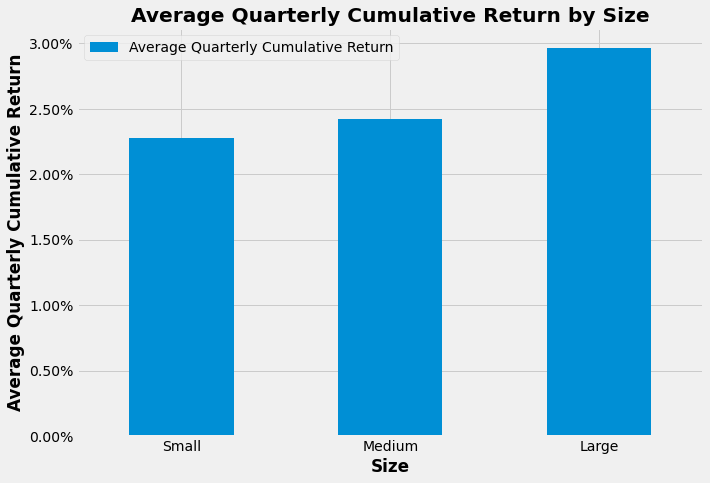

In [13]:
mutual_fund_returns_data.groupby('tna_latest_bin')['cumulative_return'].mean().plot(kind='bar', title='Average Quarterly Cumulative Return by Size')
plt.ylabel('Average Quarterly Cumulative Return')
plt.xlabel('Size')
plt.xticks(rotation=0)
plt.gca().set_xticklabels(['Small', 'Medium', 'Large'])
plt.legend(['Average Quarterly Cumulative Return'])
# change the y-axis to percentage format
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))



## Plot the Quarterly Returns for each Fund in a One Quarter Slice

### Plot a random quarter-year cumulative return for each total net assets category

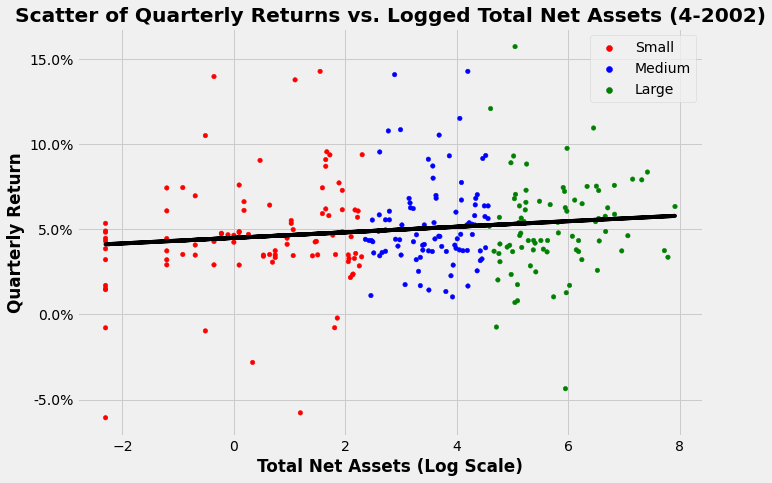

In [14]:
# create list of all unique quarter-years
quarter_year_list = mutual_fund_returns_data['quarter_year'].unique()
# sort by year and quarter for plotting purposes later on
quarter_year_list = sorted(quarter_year_list, key=lambda x: (int(x.split('-')[1]), int(x.split('-')[0])))
# choose random quarter-year to plot
quarter_year = np.random.choice(quarter_year_list, 1)[0]
# plot the cumulative returns for each mutual fund in the chosen quarter-year
mutual_fund_returns_data['log_tna_latest'] = np.log(mutual_fund_returns_data['tna_latest'] + 0.000001)
# create color key by size of mutual fund (AUM)
colors = np.where(mutual_fund_returns_data[mutual_fund_returns_data['quarter_year'] == quarter_year]['tna_latest_bin'] == 'small', 'red', np.where(mutual_fund_returns_data[mutual_fund_returns_data['quarter_year'] == quarter_year]['tna_latest_bin'] == 'medium', 'blue', np.where(mutual_fund_returns_data[mutual_fund_returns_data['quarter_year'] == quarter_year]['tna_latest_bin'] == 'large', 'green', 'black')))
mutual_fund_returns_data[mutual_fund_returns_data['quarter_year'] == quarter_year].plot.scatter(x='log_tna_latest', y='cumulative_return', title = 'Scatter of Quarterly Returns vs. Logged Total Net Assets ({})'.format(quarter_year), color=colors)
plt.xlabel('Total Net Assets (Log Scale)')
plt.ylabel('Quarterly Return')
plt.scatter([], [], c='red', label='Small')
plt.scatter([], [], c='blue', label='Medium')
plt.scatter([], [], c='green', label='Large')
plt.legend()


# add regression line to the plot
X = mutual_fund_returns_data[mutual_fund_returns_data['quarter_year'] == quarter_year]['log_tna_latest']
X = sm.add_constant(X, has_constant='skip')
y = mutual_fund_returns_data[mutual_fund_returns_data['quarter_year'] == quarter_year]['cumulative_return']
model = sm.OLS(y, X)
results = model.fit()
plt.plot(mutual_fund_returns_data[mutual_fund_returns_data['quarter_year'] == quarter_year]['log_tna_latest'], results.params[0] + results.params[1] * mutual_fund_returns_data[mutual_fund_returns_data['quarter_year'] == quarter_year]['log_tna_latest'], color='black')
# change the y-axis to percentage format
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))


## Regression with Log Total Net Assets (As sole Regressor)

In [15]:
betas = []
r_squared = []
t_stats = []

for quarter_year in quarter_year_list:
    # filter data by quarter_year
    data = mutual_fund_returns_data[mutual_fund_returns_data['quarter_year'] == quarter_year]

    # run a regression
    X = data['log_tna_latest']
    X = sm.add_constant(X, has_constant='skip')
    y = data['cumulative_return']
    model = sm.OLS(y, X)
    results = model.fit()

    # get betas
    betas.append(results.params[1])
    # get r^2 value
    r_squared.append(results.rsquared)
    # get t-statistic
    t_stats.append(results.tvalues[1])

#### Summarize the Beta Results for Log Total Net Assets Regression

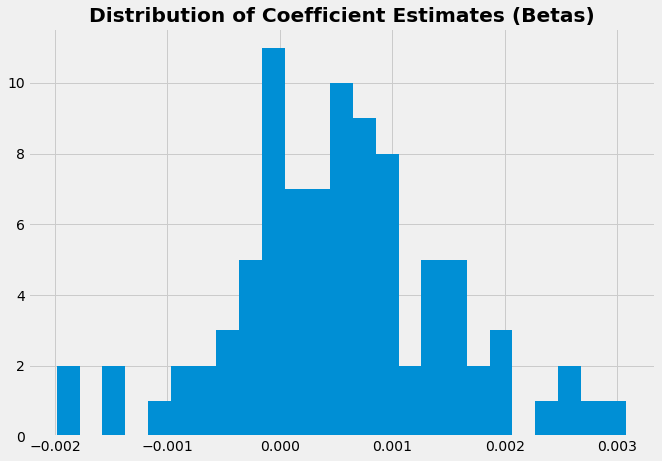

,count,mean,std,min,25%,50%,75%,max
betas,91.0,0.000527,0.000972,-0.001983,-0.000026,0.000481,0.001022,0.003082


In [16]:
# histogram of betas
plt.hist(betas, bins=25)
plt.title('Distribution of Coefficient Estimates (Betas)')
plt.show()

# summary statistics of betas distribution
betas_df = pd.DataFrame(betas).describe().T
betas_df.index = ['betas']
betas_df.head()

#### Summarize the R-Squared Results for Log Total Net Assets Regression

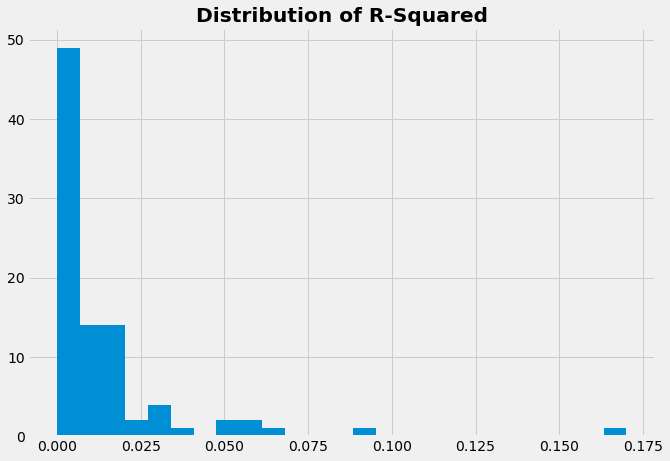

,count,mean,std,min,25%,50%,75%,max
r_squared,91.0,0.013825,0.023361,0.000002,0.001698,0.006161,0.016929,0.170021


In [17]:
# histogram of r^2 values
plt.hist(r_squared, bins=25)
plt.title('Distribution of R-Squared')
plt.show()

# summary statistics of r^2 values distribution
r_squared_df = pd.DataFrame(r_squared).describe().T
r_squared_df.index = ['r_squared']
r_squared_df.head()

#### Summarize the T-Stats Results for Log Total Net Assets Regression

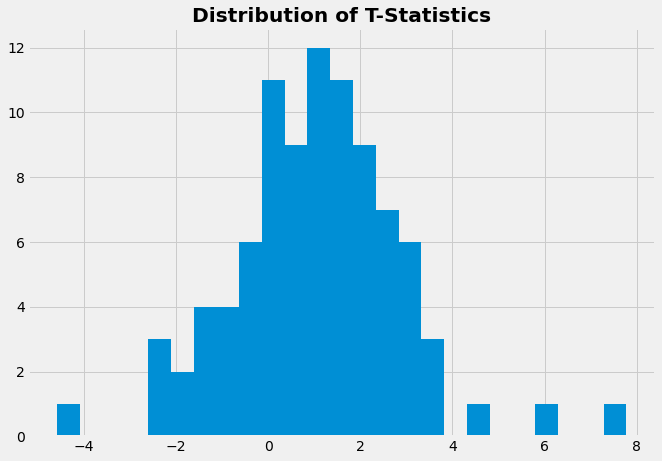

,count,mean,std,min,25%,50%,75%,max
t_stats,91.0,1.051194,1.843732,-4.582434,-0.027674,1.083177,2.05067,7.773707


In [18]:
# histogram of t-statistics
plt.hist(t_stats, bins=25)
plt.title('Distribution of T-Statistics')
plt.show()

# summary statistics of t-statistics distribution
t_stats_df = pd.DataFrame(t_stats).describe().T
t_stats_df.index = ['t_stats']
t_stats_df.head()

#### Summary table for Log Total Net Assets Regression

In [19]:
# summary statistics of betas, r^2 values, and t-statistics distributions
describe = pd.concat([r_squared_df, betas_df, t_stats_df], axis=0)
describe = describe.drop_duplicates()
describe


,count,mean,std,min,25%,50%,75%,max
r_squared,91.0,0.013825,0.023361,0.000002,0.001698,0.006161,0.016929,0.170021
betas,91.0,0.000527,0.000972,-0.001983,-0.000026,0.000481,0.001022,0.003082
t_stats,91.0,1.051194,1.843732,-4.582434,-0.027674,1.083177,2.050670,7.773707


#### Plot the Beta Results over Time for Log Total Net Assets Regression

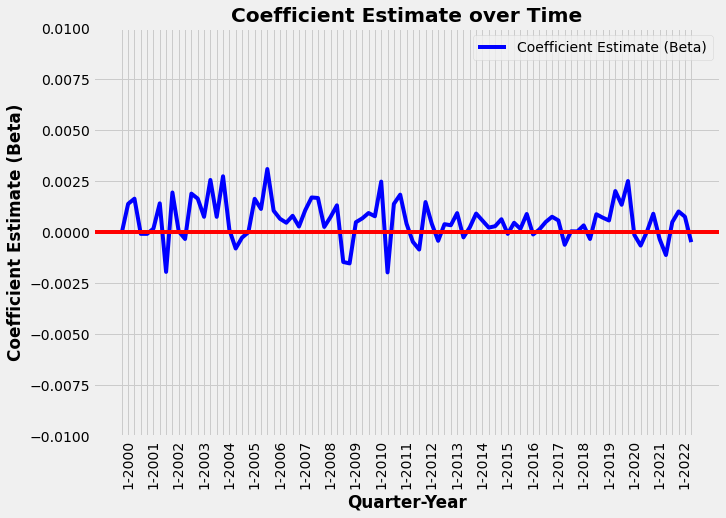

In [20]:
plt.plot(quarter_year_list, betas, color= 'blue')
plt.xticks(rotation=90)
plt.ylim(-0.01, 0.01)
plt.axhline(y=0, color='r', linestyle='-')
# only print first quarter of each year
for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
    if i % 4 != 1:
        label.set_visible(False)
plt.title('Coefficient Estimate over Time')
plt.xlabel('Quarter-Year')
plt.ylabel('Coefficient Estimate (Beta)')
plt.legend(['Coefficient Estimate (Beta)'])

#### Plot the R-Squared Results over Time for Log Total Net Assets Regression

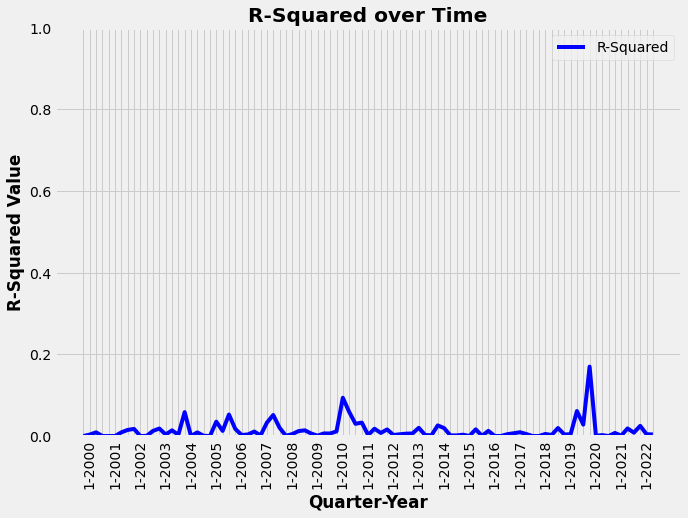

In [21]:
plt.plot(quarter_year_list, r_squared, color= 'blue')
plt.xticks(rotation=90)
plt.ylim(0, 1)
# only print first quarter of each year
for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
    if i % 4 != 1:
        label.set_visible(False)
plt.title('R-Squared over Time')
plt.xlabel('Quarter-Year')
plt.ylabel('R-Squared Value')
plt.legend(['R-Squared'])

#### Plot the T-Stats Results over Time

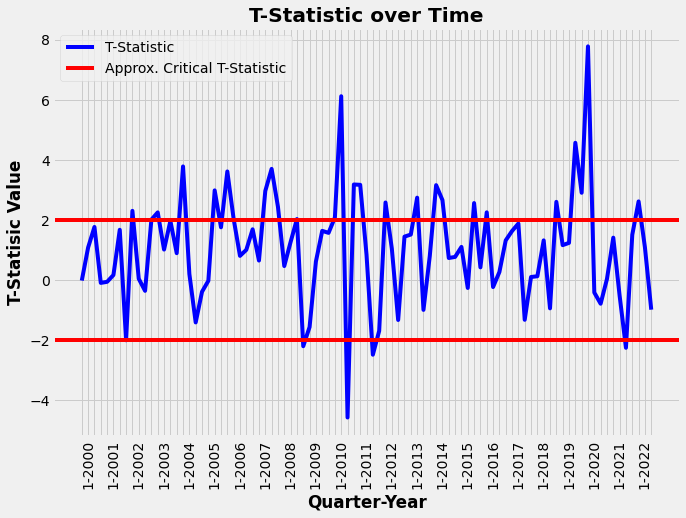

In [22]:
plt.plot(quarter_year_list, t_stats, color= 'blue')
plt.xticks(rotation=90)
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')

# only print first quarter of each year
for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
    if i % 4 != 1:
        label.set_visible(False)
plt.title('T-Statistic over Time')
plt.xlabel('Quarter-Year')
plt.ylabel('T-Statisic Value')
plt.legend(['T-Statistic', 'Approx. Critical T-Statistic'])

## Regression with Log Total Net Assets and Retail Funds as Regressors

In [23]:
betas = []
r_squared = []
t_stats = []

for quarter_year in quarter_year_list:
    # filter data by quarter_year
    data = mutual_fund_returns_data[mutual_fund_returns_data['quarter_year'] == quarter_year]
   
    # create encoding for categorical variable
    data['retail_fund'] = data['retail_fund'].replace('Y', 1)
    data['retail_fund'] = data['retail_fund'].replace('N', 0)

    # run a regression
    X = data[['log_tna_latest', 'retail_fund']]
    X = sm.add_constant(X, has_constant='skip')
    y = data['cumulative_return']
    model = sm.OLS(y, X)
    results = model.fit()

    # get betas
    betas.append(results.params[1])
    # get r^2 value
    r_squared.append(results.rsquared)
    # get t-statistic
    t_stats.append(results.tvalues[1])

#### Summarize the Beta Results for Log Total Net Assets and Retail Funds Regression

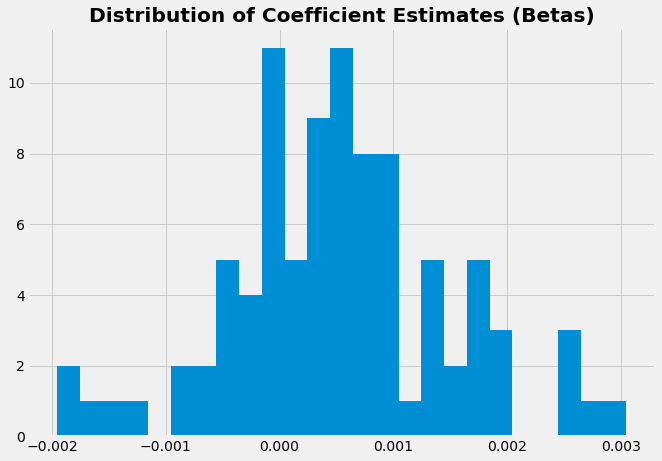

,count,mean,std,min,25%,50%,75%,max
betas,91.0,0.000519,0.000974,-0.001957,-0.000029,0.000497,0.000949,0.003048


In [24]:
# histogram of betas
plt.hist(betas, bins=25)
plt.title('Distribution of Coefficient Estimates (Betas)')
plt.show()

# summary statistics of betas distribution
betas_df = pd.DataFrame(betas).describe().T
betas_df.index = ['betas']
betas_df.head()

#### Summarize the R-Squared Results for Log Total Net Assets and Retail Funds Regression

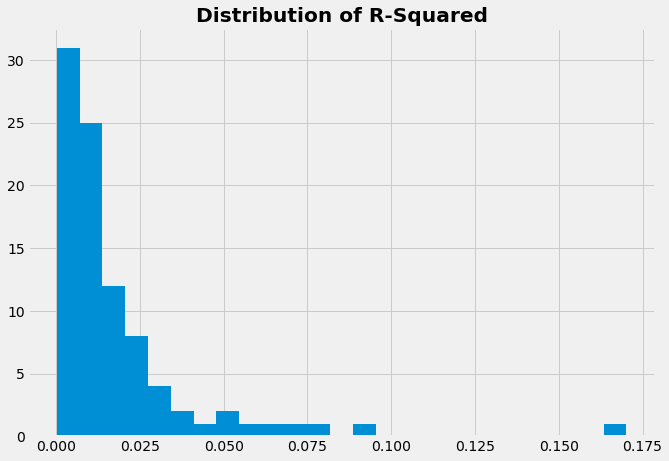

,count,mean,std,min,25%,50%,75%,max
r_squared,91.0,0.017826,0.0241,0.00025,0.004646,0.009683,0.020637,0.170185


In [25]:
# histogram of r^2 values
plt.hist(r_squared, bins=25)
plt.title('Distribution of R-Squared')
plt.show()

# summary statistics of r^2 values distribution
r_squared_df = pd.DataFrame(r_squared).describe().T
r_squared_df.index = ['r_squared']
r_squared_df.head()

#### Summarize the T-Stats Results for Log Total Net Assets and Retail Funds Regression

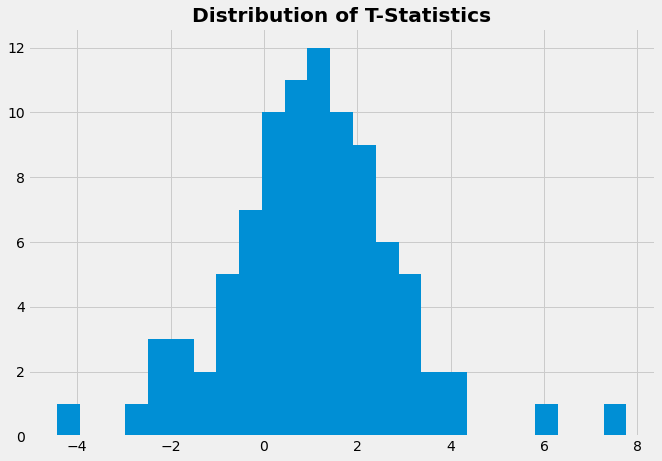

,count,mean,std,min,25%,50%,75%,max
t_stats,91.0,1.019309,1.831276,-4.43358,-0.022655,1.033845,2.097628,7.763869


In [26]:
# histogram of t-statistics
plt.hist(t_stats, bins=25)
plt.title('Distribution of T-Statistics')
plt.show()

# summary statistics of t-statistics distribution
t_stats_df = pd.DataFrame(t_stats).describe().T
t_stats_df.index = ['t_stats']
t_stats_df.head()

#### Summary table for Log Total Net Assets and Retail Funds Regression

In [27]:
# summary statistics of betas, r^2 values, and t-statistics distributions
describe = pd.concat([r_squared_df, betas_df, t_stats_df], axis=0)
describe = describe.drop_duplicates()
describe


,count,mean,std,min,25%,50%,75%,max
r_squared,91.0,0.017826,0.024100,0.000250,0.004646,0.009683,0.020637,0.170185
betas,91.0,0.000519,0.000974,-0.001957,-0.000029,0.000497,0.000949,0.003048
t_stats,91.0,1.019309,1.831276,-4.433580,-0.022655,1.033845,2.097628,7.763869


#### Plot the Beta Results over Time for Log Total Net Assets and Retail Funds Regression

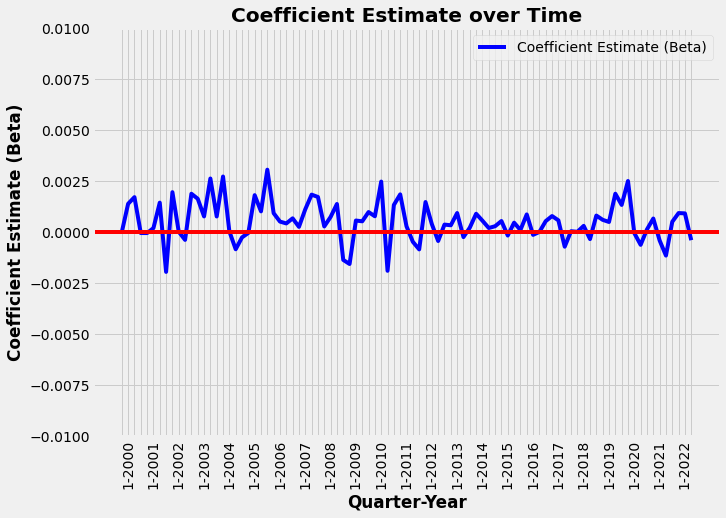

In [28]:
plt.plot(quarter_year_list, betas, color= 'blue')
plt.xticks(rotation=90)
plt.ylim(-0.01, 0.01)
plt.axhline(y=0, color='r', linestyle='-')
# only print first quarter of each year
for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
    if i % 4 != 1:
        label.set_visible(False)
plt.title('Coefficient Estimate over Time')
plt.xlabel('Quarter-Year')
plt.ylabel('Coefficient Estimate (Beta)')
plt.legend(['Coefficient Estimate (Beta)'])

#### Plot the R-Squared Results over Time for Log Total Net Assets and Retail Funds Regression

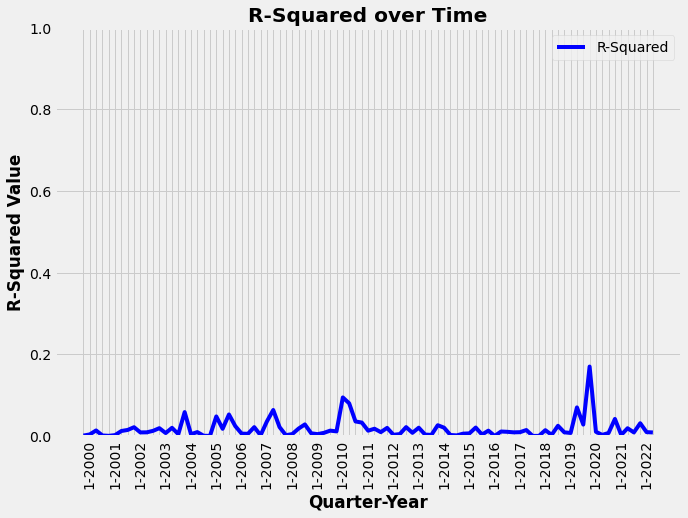

In [29]:
plt.plot(quarter_year_list, r_squared, color= 'blue')
plt.xticks(rotation=90)
plt.ylim(0, 1)
# only print first quarter of each year
for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
    if i % 4 != 1:
        label.set_visible(False)
plt.title('R-Squared over Time')
plt.xlabel('Quarter-Year')
plt.ylabel('R-Squared Value')
plt.legend(['R-Squared'])

#### Plot the T-Stats Results over Time for Log Total Net Assets and Retail Funds Regression

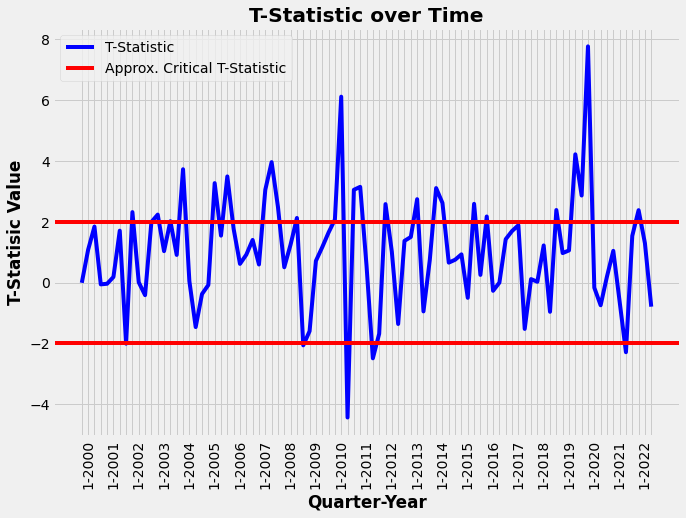

In [30]:
plt.plot(quarter_year_list, t_stats, color= 'blue')
plt.xticks(rotation=90)
plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')

# only print first quarter of each year
for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
    if i % 4 != 1:
        label.set_visible(False)
plt.title('T-Statistic over Time')
plt.xlabel('Quarter-Year')
plt.ylabel('T-Statisic Value')
plt.legend(['T-Statistic', 'Approx. Critical T-Statistic'])